In [1]:
import ee
import numpy as np
import pandas as pd
import geopandas as gp
from tqdm import tqdm

import matplotlib.pyplot as plt

ee.Initialize()

In [29]:
# Set up the data objects to query EE
data = {}

# Image collection, variable name, scaling factor, spatial res
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1, 4000]
data['persiann'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1, 25000]
data['gpm'] = [ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V06"), "precipitation", 720, 12500]
data['modis_lst'] = [ee.ImageCollection("MODIS/061/MOD11A1"), "LST_Day_1km", 30* 0.02, 25000]

<AxesSubplot:>

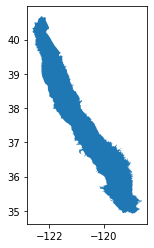

In [3]:
gdf = gp.read_file("../shape/cv.shp")
gdf.plot()

In [76]:
# Functions 

# Convert gdf to earth engine object 
def gdf_to_ee_poly(gdf, simplify = True):

    if simplify:
        gdf = gdf.geometry.simplify(0.01)
    
    lls = gdf.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)

    return area

def get_ims(dataset, startdate,enddate, area, return_dates = False, table = False, monthly_mean = False,  monthly_sum = False):
    
    '''
    Returns gridded images for EE datasets 
    '''

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    native_res = dataset[3]

    dt_idx = pd.date_range(startdate,enddate, freq='MS')
    ims = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()

    print("processing:")
    print("{}".format(ImageCollection.first().getInfo()['id']))

    for i in tqdm(num_steps):

        start = ee.Date(startdate).advance(i, 'month')
        end = start.advance(1, 'month');

        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).set('system:time_start', end.millis())
        im2 = ee.ImageCollection(im.mean())
        result = im2.getRegion(area,native_res,"epsg:4326").getInfo()
        ims.append(result)

    results = []
    print("postprocesing")

    for im in tqdm(ims):
        header, data = im[0], im[1:]

        df = pd.DataFrame(np.column_stack(data).T, columns = header)
        df.latitude = pd.to_numeric(df.latitude)
        df.longitude = pd.to_numeric(df.longitude)
        df[var] = pd.to_numeric(df[var])

        images = []

        for idx,i in enumerate(df.id.unique()):

            t1 = df[df.id==i]
            arr = array_from_df(t1,var)
            arr[arr == 0] = np.nan
            images.append(arr*scaling_factor)# This is the only good place to apply the scaling factor. 

        results.append(images) 

    print("====COMPLETE=====")

    return [item for sublist in results for item in sublist] 
    
def array_from_df(df, variable):    

    '''
    Convets a pandas df with lat, lon, variable to a numpy array 
    '''

    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

def write_raster(array,gdf,outfn):
    '''
    converts a numpy array and a geopandas gdf to a geotiff
    Data values are stored in np.array
    spatial coordinates stored in gdf
    outfn - outpath
    '''
    
    xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
    xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
    nrows, ncols = array.shape
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform =(xmin,xres,0,ymax,0, -yres)   

    output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, 1 , gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(geotransform)  # Specify coords
    srs = osr.SpatialReference()                 # Establish encoding
    srs.ImportFromEPSG(4326)                     # WGS84 lat long
    output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
    output_raster.GetRasterBand(1).WriteArray(array)   # Write array to raster
    
    print("wrote {}".format(outfn))
    return outfn


In [5]:
# Convert gdf to ee object
area = gdf_to_ee_poly(gdf)

# specify start / end 
startdate = '2001-09-30'
enddate = '2021-09-30'

prism = get_ims(data['gpm'], startdate, enddate, area)

  0%|          | 0/240 [00:00<?, ?it/s]

processing:
NASA/GPM_L3/IMERG_MONTHLY_V06/20000601000000


  4%|▍         | 10/240 [00:00<00:02, 92.94it/s]

postprocesing


100%|██████████| 240/240 [00:02<00:00, 114.59it/s]

====COMPLETE=====


In [6]:
# stack the ims and calc mean
annual_mean = np.nanmean(np.dstack(prism), axis = 2)
timeseries = np.array([np.nanmean(x) for x in prism])

<ipython-input-6-89a32555be6b>:2: RuntimeWarning: Mean of empty slice
  annual_mean = np.nanmean(np.dstack(prism), axis = 2)


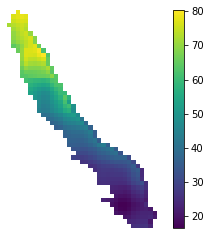

In [7]:
# plot
plt.imshow(annual_mean)
plt.colorbar()
plt.axis('off')
plt.show()

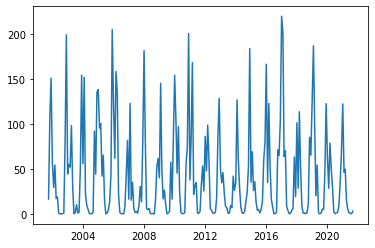

In [8]:
dates = pd.date_range(startdate,enddate, freq = "MS")
plt.plot(dates, timeseries)

In [83]:
data['modis_lst'] = [ee.ImageCollection("MODIS/061/MOD11A2"), "LST_Day_1km", 0.02, 12500]

# specify start / end 
startdate = '2001-09-30'
enddate = '2003-09-30'

modis_lst = get_ims(data['modis_lst'], startdate, enddate, area)

  0%|          | 0/24 [00:00<?, ?it/s]

processing:
MODIS/061/MOD11A2/2000_02_18


100%|██████████| 24/24 [00:00<00:00, 140.56it/s]

postprocesing
====COMPLETE=====


In [84]:
# stack the ims and calc mean
annual_mean_lst = np.nanmean(np.dstack(modis_lst), axis = 2)
timeseries_lst = np.array([np.nanmean(x) for x in modis_lst])

<ipython-input-84-3406d17c4b17>:2: RuntimeWarning: Mean of empty slice
  annual_mean_lst = np.nanmean(np.dstack(modis_lst), axis = 2)


In [85]:
len(modis_lst)

24

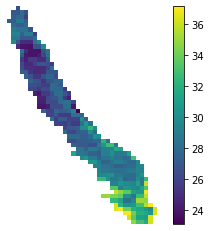

In [86]:
# plot
plt.imshow(annual_mean_lst-273)
plt.colorbar()
plt.axis('off')
plt.show()

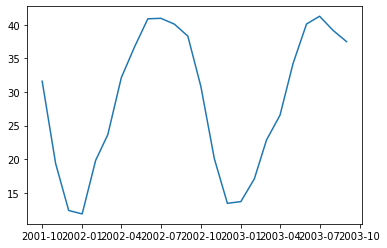

In [87]:
dates = pd.date_range(startdate,enddate, freq = "MS")
plt.plot(dates,timeseries_lst-273)